# Project Option 1 FIFA Dataset

## Tung-Yu Hsiao (tungyuh)
## Kaiyu Guan (kaiyug)

## Phase I

### Task 1 - Build and populate necessary tables 

In [1]:
import pyspark
from pyspark import SparkContext, SQLContext 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.sql.functions import lit
from functools import reduce

#### Initiating Spark Session

In [2]:
# Spark context access the hardware-level and software-leve configuration 
# For Spark 2.X
# Spark Session provides a unified interface for interacting with 
# different Spark APIs and allows applications to run on a Spark cluster. 

import pyspark
from pyspark import SparkContext, SQLContext 
from pyspark.sql import SparkSession

appName = "FIFA_project"
master = "local"

### Create Configuration object for Spark.
# setAppName: set the name of the application 
# setMaster: set Spark cluster to use, here "local" indicating local machine
# set("setting configuration", "attribute"): The configuration could be "spark.driver.host" or "spark.executor.memory"
# and the second entry indicating the corresponding configuration 

conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master) 

# Create Spark Context with the new configurations rather than relying on the default one
# SparkContext 
sc = SparkContext.getOrCreate(conf=conf) # getOrCreate get the current configuration or create a new one

# Linking to SQL API
# You need to create SQL Context to conduct some database operations like what we will see later.
# SQLContext
sqlContext = SQLContext(sc) # Connected to SQL API

# Spark Session 
spark = SparkSession.builder.master("local[*]").appName(appName).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/16 22:42:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Users/tungyuhsiao/opt/anaconda3/envs/python_3.8/lib/python3.8/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/11/16 22:42:34 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


#### Ingesting Data into Spark DF

In [3]:
# Store data into one spark df
from pyspark.sql.functions import lit
from functools import reduce

file_paths = ["./fifa_dataset/players_%d.csv" % n for n in range(15,23)]

# Read each CSV file and add a new column
dataframes = [spark.read.csv(file_path, header=True, inferSchema=True) for file_path in file_paths]

# Add a new column to each DataFrame
year = [str(n) for n in range(2015,2023)]
dataframes_with_column = [dataframes[i].withColumn("year", lit(year[i])) for i in range(len(dataframes))]

# Union all DataFrames
fifa = reduce(lambda df1, df2: df1.union(df2), dataframes_with_column)

# Add a unique primary key id column to dataframe
fifa = fifa.withColumn("id", monotonically_increasing_id())

# Show the final DataFrame
fifa.show(1, vertical = True)

23/11/16 22:42:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0-------------------------------------------
 sofifa_id                   | 158023               
 player_url                  | https://sofifa.co... 
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 player_positions            | CF                   
 overall                     | 93                   
 potential                   | 95                   
 value_eur                   | 1.005E8              
 wage_eur                    | 550000.0             
 age                         | 27                   
 dob                         | 1987-06-24           
 height_cm                   | 169                  
 weight_kg                   | 67                   
 club_team_id                | 241.0                
 club_name                   | FC Barcelona         
 league_name                 | Spain Primera Div... 
 league_level                | 1                    
 club_position               | CF             

In [4]:
# Check if all records are unique

print(fifa.distinct().count() == fifa.count())
fifa.count()

True


142079

In [5]:
# Schema
fifa.printSchema()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: double (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: date (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- nationality_id: integer (nullable = true)
 

#### Write Spark DF to Postgres

In [6]:
# Wirte Spark df to postgres database table

# Specify the primary key columns
primary_key_columns = "id"  # Replace with your actual column names



db_properties={}
#update your db username
db_properties['username']="tungyuhsiao"
#update your db password
db_properties['password']="10430041"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "fifa"
db_properties["primary_key_cloumns"] = "id"



# Write the DataFrame to PostgreSQL with the specified primary key
fifa.write.format("jdbc") \
    .mode("overwrite").option("url", db_properties["url"]) \
    .option("dbtable", db_properties["table"]) \
    .option("user", db_properties["username"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]).save()

23/11/16 22:42:46 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [7]:
# Wirte Spark df to postgres database table
fifa = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("driver", db_properties['driver'])\
    .load()

### Task 2 - Conduct analytics on your dataset

#### Calculating Players Contract Ending 2023 in 2022

In [8]:
# Define a function to extract top N team with players contract ending in 2023

def getXClubWithMostPlayerContractEnd(X:int):
    # Filter players contract 
    fifa_2022 = fifa.filter(col("year") == "2022")


    # Filter players contract ending at 2023
    fifa_2022_p2023 = fifa_2022.filter(col("club_contract_valid_until") == 2023)

    # show count of players contract ending in 2023 by clubs 
    playersByClub = fifa_2022_p2023.groupby("club_name").count().sort(col("count"), ascending = False)

    # Show the team with most players contract ending in 2023
    top_teams = playersByClub.orderBy(col('count').desc()).limit(X)

    # DF excluding Top X Selected teams
    dfExcludeTopN = playersByClub.subtract(top_teams)
    
    # handle special scenario (where there are multiple teams sharing same amount of players ending in 2023)
    Edge = top_teams.tail(1)[0][1]  # extract the ranked team
    Edge_club = dfExcludeTopN.filter(col("count") == Edge)  # extract team left in the subtracted df where they share same amount of player as the last ranked team 

    output = top_teams.union(Edge_club)
    output.show()
    return output

In [9]:
# Customize X for user input
# X = input("Insert number of desired teams to extract")

X = 5
teams = getXClubWithMostPlayerContractEnd(5)

+--------------------+-----+
|           club_name|count|
+--------------------+-----+
|En Avant de Guingamp|   19|
| Club Atlético Lanús|   17|
|       Lechia Gdańsk|   17|
|            Barnsley|   16|
|        Kasimpaşa SK|   16|
|        Bengaluru FC|   16|
+--------------------+-----+



#### List the Y clubs with highest average number of players that are older than 27 years across all years 

In [10]:
def highestAVGPlayerAge(Y:int):
    oldPlayer = fifa.filter(col("age") > 27)


    # Identify & remove players not affiliated to a club 
    oldPlayerFiltered = oldPlayer.na.drop(subset = ["club_name", "age"])
    # oldPlayerFiltered.show()


    # Group by club 
    count_oldPlayer = oldPlayerFiltered.groupBy(col("club_name"), col("year")).count()
    count_oldPlayer_ordered = count_oldPlayer.groupby(col("club_name")).mean().sort(col("avg(count)"), ascending = False)
    # count_oldPlayer_ordered.show()

    firstN = count_oldPlayer_ordered.limit(Y)

    # handle special scenario

    Edge = firstN.tail(1)[0][1]

    # DF excluding Top X Selected teams
    dfExcludeTopN = count_oldPlayer_ordered.subtract(firstN)

    # handle special scenario (where there are multiple teams sharing same amount of players ending in 2023)
    Edge = firstN.tail(1)[0][1]  # extract the ranked team
    Edge_club = dfExcludeTopN.filter(col("avg(count)") == Edge)  # extract team left in the subtracted df where they share same amount of player as the last ranked team 

    output = firstN.union(Edge_club)
    output.show()

    return output

In [11]:
# Customize Y for user input
# Y = input("Insert number of desired teams to extract")
Y = 6
old_teams = highestAVGPlayerAge(Y)

+--------------------+----------+
|           club_name|avg(count)|
+--------------------+----------+
|  Dorados de Sinaloa|      19.0|
| Matsumoto Yamaga FC|      19.0|
| Shanghai Shenhua FC|      18.5|
|          Qingdao FC|      18.0|
|Club Deportivo Jo...|      17.5|
|            Altay SK|      17.0|
|         Guaireña FC|      17.0|
+--------------------+----------+



####  Find the most frequent nation_position in the dataset for each year

In [12]:
# Check NULL values in column national_position 
# Show players who are not affiliated to a national team 
fifa.select(col("long_name")).filter(col("nation_position").isNull())

# Remove players not in nation teams
nationPlayers = fifa.na.drop(subset = ["nation_position"])
position_count = nationPlayers.groupBy(["year", "nation_position"]).count()

# Max by year
position_count.join(position_count.groupBy("year").agg(max("count").alias("count")), on = "count", how="leftsemi").sort("year").show()

+-----+----+---------------+
|count|year|nation_position|
+-----+----+---------------+
|  564|2015|            SUB|
|  511|2016|            SUB|
|  564|2017|            SUB|
|  600|2018|            SUB|
|  576|2019|            SUB|
|  588|2020|            SUB|
|  588|2021|            SUB|
|  396|2022|            SUB|
+-----+----+---------------+



## Phase II

### Task 3 Machine Learning Modeling

#### Data Preparation

For the preparation stage, we are going to prepare our data in two stage. 
- We are going to first clean our data- remove unnessary columns, null-value handling, data type casting, etc.
- Then we are going to create a pipeline that prepare the cleaned data into a dataframe such that we can use it for model fitting.

In [13]:
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler, IndexToString
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import pandas as pd

In [14]:
# all comluns in fifa df
df = fifa
col_names = df.columns

Even though the columns are named in a nice format, our dataset has uninformative columns (`urls`) and repeated columns (e.g. `league_name` and `league_id`). Therefore, we chose to drop these columns are they may introduce bias to our prediction model. We then decide to drop columns that falls under the following categories:
- urls
- duplicated columns
- characteristic that does not contribute to the score of a player (e.g. race)

In [15]:
# Columns drop (dropping urls, duplicated columns, uninformative names, tags)
drop_cols = ["player_url", "short_name", "long_name", "league_name", "club_loaned_from", "player_face_url", "player_traits", "dob",
             "club_position", "player_tags", "club_logo_url", "club_flag_url", "nation_logo_url", "nation_flag_url", "player_positions", 
             "sofifa_id",  "club_jersey_number", "club_joined", "club_contract_valid_until", "nationality_id", "weak_foot", "id",
             "nation_jersey_number",  "nation_team_id", "real_face", "club_loaned_from", "nation_position", "preferred_foot", "club_team_id",
             "club_name", "body_type", "nationality_name", "work_rate"
]

There are also numeric columns that are stored as string. We are going to add/subtract the numbers stored in each cell then convert them to numeric.

In [16]:
sub_numeric = [
    "ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "cm", "rcm",
    "rm", "lwb", "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk"
]

In [17]:
# all nominal columns
nominal_cols = [
    "league_level", "year"
]

#### Date Cleaning

In [18]:
# casting columns from string to int
cast_col = ["release_clause_eur", "mentality_composure"]
df = df.withColumn("release_clause_eur", df["release_clause_eur"].cast("integer"))
df = df.withColumn("mentality_composure", df["mentality_composure"].cast("integer"))

# handle the sub_numeric columns before imputing
def combine_numbers(input_string):
    if "+" in input_string:
        numbers = input_string.split('+')
        result = int(numbers[0]) + int(numbers[1])
    elif "-" in input_string:
        numbers = input_string.split('-')
        result = int(numbers[0]) - int(numbers[1])
    else:
        result = int(input_string)
    return result

add_numbers_udf = udf(combine_numbers, IntegerType())

for col_name in sub_numeric:
    df = df.withColumn(col_name, add_numbers_udf(col_name))

df.show(1, vertical=True)

-RECORD 0-------------------------------------------
 sofifa_id                   | 158023               
 player_url                  | https://sofifa.co... 
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 player_positions            | CF                   
 overall                     | 93                   
 potential                   | 95                   
 value_eur                   | 1.005E8              
 wage_eur                    | 550000.0             
 age                         | 27                   
 dob                         | 1987-06-24           
 height_cm                   | 169                  
 weight_kg                   | 67                   
 club_team_id                | 241.0                
 club_name                   | FC Barcelona         
 league_name                 | Spain Primera Div... 
 league_level                | 1                    
 club_position               | CF             

In [19]:
# check for null after column dropping 
df_drop = df.drop(*drop_cols)
df_count_null = df_drop.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_drop.columns])

df_count_null.show(vertical=True)

-RECORD 0-----------------------------
 overall                     | 0      
 potential                   | 0      
 value_eur                   | 1897   
 wage_eur                    | 1622   
 age                         | 0      
 height_cm                   | 0      
 weight_kg                   | 0      
 league_level                | 2015   
 skill_moves                 | 0      
 international_reputation    | 0      
 release_clause_eur          | 55582  
 pace                        | 15791  
 shooting                    | 15791  
 passing                     | 15791  
 dribbling                   | 15791  
 defending                   | 15791  
 physic                      | 15791  
 attacking_crossing          | 0      
 attacking_finishing         | 0      
 attacking_heading_accuracy  | 0      
 attacking_short_passing     | 0      
 attacking_volleys           | 0      
 skill_dribbling             | 0      
 skill_curve                 | 0      
 skill_fk_accuracy       

The `goalkeeping_speed` columns is almost empty. After carefully examine the data stored in the `goalkeeping_speed` columns, we found that this columns only has value for goalkeepers. We then decide to drop this column as there are other important features that contributes to the overall score for a goal keeper. For the other columns, we decide to impute the missing value with the median of the columns.

The `league_level` columns is a nominal columns, we therefore also drop the rows with missing value in this column.

In [20]:
df_drop = df_drop.withColumn("league_level", df["league_level"].cast("String"))

df_drop = df_drop.drop("goalkeeping_speed")
df_drop = df_drop.filter(df_drop.league_level.isNotNull())

For the other columns with null values, we decide to imputed it with the meidan of each column.

In [21]:
# imputation
columns_to_be_imputed = [
    "value_eur", "wage_eur", "pace", "shooting", "passing", "dribbling", 
    "defending", "physic", "release_clause_eur", "mentality_composure"
]
value_not_in_dataset = -200

# Replace None/Missing Value with a value that can't be present in the dataset.
df_with_filled_na = df_drop.fillna(-200, columns_to_be_imputed)

#Create new columns with imputed values. New columns will be suffixed with "_imputed"
imputer = Imputer (
            inputCols=columns_to_be_imputed,
            outputCols=["{}_imputed".format(c) for c in columns_to_be_imputed])\
            .setStrategy("median").setMissingValue(value_not_in_dataset)

df_imputed = imputer.fit(df_with_filled_na).transform(df_with_filled_na)
# we will drop the old column without imputation. We have only one column to be imputed

df_imputed_enhanced = df_imputed
for i in range(len(columns_to_be_imputed)):
    df_imputed_enhanced = df_imputed_enhanced.drop(columns_to_be_imputed[i])

# We will rename our newly imputed column with the correct name
df_imputed = df_imputed_enhanced
for col_names in columns_to_be_imputed:
    df_imputed = df_imputed.withColumnRenamed(f"{col_names}_imputed", f"{col_names}")

In [22]:
df_count_null_2 = df_imputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_imputed.columns])
df_count_null_2.show(vertical=True)

-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 league_level                | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                 | 0   
 skill_fk_accuracy           | 0   
 skill_long_passing          | 0   
 skill_ball_control          | 0   
 movement_acceleration       | 0   
 movement_sprint_speed       | 0   
 movement_agility            | 0   
 movement_reactions          | 0   
 movement_balance            | 0   
 power_shot_power            | 0   
 power_jumping               | 0   
 power_stamina               | 0   
 power_strength             

In [23]:
# numeric columns
numeric_col = list(np.setdiff1d(np.array(df_imputed.columns), np.array(nominal_cols)))

In [24]:
# Handle outliers
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_col:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [25]:
df_with_outlier_handling = find_outliers(df_imputed)
df_with_outlier_handling.groupby("total_outliers").count().sort("total_outliers", ascending=False).show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|            40|    2|
|            39|   18|
|            38|   37|
|            37|  113|
|            36|  231|
|            35|  417|
|            34|  710|
|            33|  626|
|            32|  430|
|            31|  299|
|            30|  263|
|            29|  317|
|            28|  232|
|            27|  176|
|            26|  235|
|            25|  226|
|            24|  231|
|            23|  299|
|            22|  353|
|            21|  342|
+--------------+-----+
only showing top 20 rows



In [26]:
# remove rows with more than 25 outliers
df_imputed_with_outliers_handled = df_with_outlier_handling.filter(df_with_outlier_handling['total_Outliers']<=25)

# drop the total_outlier column since we no longer need it
df_imputed_with_outliers_handled = df_imputed_with_outliers_handled.drop("total_Outliers")

In [27]:
# handle Correlation

# Find correlation
correlation_matrix = df_imputed_with_outliers_handled[numeric_col].toPandas().corr()

# Set display options to show all columns and rows without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Print the correlation matrix
correlation_matrix

,age,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,cam,cb,cdm,cf,cm,defending,defending_marking_awareness,defending_sliding_tackle,defending_standing_tackle,dribbling,gk,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,height_cm,international_reputation,lam,lb,lcb,lcm,ldm,lf,lm,ls,lw,lwb,mentality_aggression,mentality_composure,mentality_interceptions,mentality_penalties,mentality_positioning,mentality_vision,movement_acceleration,movement_agility,movement_balance,movement_reactions,movement_sprint_speed,overall,pace,passing,physic,potential,power_jumping,power_long_shots,power_shot_power,power_stamina,power_strength,ram,rb,rcb,rcm,rdm,release_clause_eur,rf,rm,rs,rw,rwb,shooting,skill_ball_control,skill_curve,skill_dribbling,skill_fk_accuracy,skill_long_passing,skill_moves,st,value_eur,wage_eur,weight_kg
age,1.000000,0.114147,0.048246,0.129227,0.118151,0.117052,0.086401,0.183493,0.193456,0.080453,0.155485,0.246540,0.134809,0.083319,0.102164,0.153716,0.190757,0.152432,0.158169,0.156535,0.163698,0.152484,0.100522,0.256656,0.086401,0.133365,0.183493,0.155485,0.193456,0.080453,0.063990,0.105100,0.051937,0.128878,0.253056,0.313235,0.181430,0.113337,0.058215,0.178298,-0.225625,-0.055631,-0.128307,0.445984,-0.217677,0.451972,-0.184014,0.314594,0.404266,-0.200798,0.170518,0.136265,0.186489,0.072743,0.331684,0.086401,0.133365,0.183493,0.155485,0.193456,0.050329,0.080453,0.063990,0.105100,0.051937,0.128878,0.222436,0.058270,0.124900,-0.022277,0.177939,0.171459,0.000463,0.105100,0.068666,0.167909,0.240914
attacking_crossing,0.114147,1.000000,0.595294,0.374151,0.770427,0.633982,0.829483,0.437225,0.624785,0.812480,0.830443,0.023113,0.336202,0.332885,0.347898,0.560858,-0.566147,-0.590667,-0.587929,-0.587074,-0.589830,-0.590777,-0.456621,0.186227,0.829483,0.655043,0.437225,0.830443,0.624785,0.812480,0.879417,0.761483,0.864493,0.743170,0.403151,0.482003,0.349175,0.588227,0.738134,0.665505,0.598107,0.644001,0.558616,0.342906,0.571445,0.369798,0.315620,0.635545,0.002146,0.254707,0.052479,0.697044,0.598466,0.603642,-0.090117,0.829483,0.655043,0.437225,0.830443,0.624785,0.180321,0.812480,0.879417,0.761483,0.864493,0.743170,0.370893,0.807165,0.803159,0.825925,0.725515,0.718212,0.645797,0.761483,0.222177,0.248496,-0.378230
attacking_finishing,0.048246,0.595294,1.000000,0.384916,0.595434,0.864709,0.832044,0.001391,0.208226,0.877115,0.667887,-0.494029,-0.163306,-0.205373,-0.167735,0.584483,-0.480233,-0.502569,-0.499487,-0.496900,-0.501179,-0.500859,-0.324821,0.167704,0.832044,0.188102,0.001391,0.667887,0.208226,0.877115,0.791732,0.898345,0.843606,0.296838,0.139098,0.451164,-0.154707,0.811917,0.868385,0.672727,0.527734,0.582447,0.445791,0.280105,0.508114,0.291212,0.294634,0.427811,-0.099849,0.233915,0.011264,0.853751,0.743026,0.411185,-0.060107,0.832044,0.188102,0.001391,0.667887,0.208226,0.177725,0.877115,0.791732,0.898345,0.843606,0.296838,0.797097,0.746932,0.721081,0.792878,0.652727,0.436024,0.687598,0.898345,0.220117,0.222574,-0.259984
attacking_heading_accuracy,0.129227,0.374151,0.384916,1.000000,0.558930,0.417385,0.484853,0.669984,0.634688,0.511465,0.568368,0.192432,0.502630,0.469167,0.497907,-0.076116,-0.666068,-0.684346,-0.682632,-0.678868,-0.680901,-0.684334,0.099158,0.156789,0.484853,0.634092,0.669984,0.568368,0.634688,0.511465,0.497393,0.600948,0.472216,0.615229,0.644812,0.414683,0.482802,0.472672,0.435421,0.220492,0.178246,0.126140,0.024623,0.274699,0.241675,0.304367,-0.204341,-0.012825,0.414652,0.193528,0.337236,0.417648,0.464031,0.553193,0.473991,0.484853,0.634092,0.669984,0.568368,0.634688,0.126205,0.511465,0.497393,0.600948,0.472216,0.615229,0.025447,0.579021,0.350663,0.448183,0.322172,0.428871,0.327656,0.600948,0.156541,0.203281,0.101077
attacking_short_passing,0.118151,0.770427,0.595434,0.558930,1.000000,0.634767,0.886161,0.595113,0.789205,0.845345,0.950002,0.126777,0.451331,0.429572,0.464066,0.482686,-0.622640,-0.658

In [28]:
correlation_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)

age                          age                            1.000000
ldm                          ldm                            1.000000
lam                          cam                            1.000000
                             lam                            1.000000
                             ram                            1.000000
lb                           lb                             1.000000
                             rb                             1.000000
lcb                          cb                             1.000000
                             lcb                            1.000000
                             rcb                            1.000000
lcm                          cm                             1.000000
                             lcm                            1.000000
                             rcm                            1.000000
ldm                          cdm                            1.000000
                             rdm  

Correlation between:
- `lam`, `cam`, `ram`, `cf`, `lf`, `rf`, `lm`, `rm`, `lw`, `rw`, `ls`, `rs`, `st`, `lcm`, `cm`, `rcm`, `skill_dribbling`, `skill_ball_control`,
- `lb`, `rb`, `lwb`, `rwb`, `ldm`, `cdm`, `rdm`, `cb`, `rcb`, `lcb`
- `lcb`, `rcb`, `cb`, `defending_sliding_tackle`, `defending_standing_tackle`, `defending_marking_awareness`, `mentality_interceptions`
- `goalkeeping_reflexes`, `gk`, `goalkeeping_diving`, `goalkeeping_positioning`, `goalkeeping_handling`, `goalkeeping_kicking`
- `attacking_short_passing`, `rcm`, `lcm`, `cm`,
- `mentality_positioning`, `cf`, `lf`, `rf`, `ls`, `rs`, `st`, `lw`, `rw`, `lam`, `cam`, `ram`,

- `movement_sprint_speed`, `movement_acceleration`

Therefore, we are dropping the following columns:
- `lam`, `cam`, `ram`, `cf`, `lf`, `rf`, `lm`, `rm`, `lw`, `rw`, `ls`, `rs`, `st`, `lcm`, `cm`, `rcm`, `skill_dribbling`, `lb`, `rb`, `lwb`, `rwb`, `ldm`, `cdm`, `rdm`, `rcb`, `lcb`, `defending_sliding_tackle`, `defending_standing_tackle`, `defending_marking_awareness`, `mentality_interceptions`, `goalkeeping_reflexes`, `goalkeeping_diving`, `goalkeeping_positioning`, `goalkeeping_handling`, `goalkeeping_kicking`, and `movement_acceleration`. 

In [29]:
# remove correlated columns
col_corr_drop = ['lam', 'cam', 'ram', 'cf', 'lf', 'rf', 'lm', 'rm', 'lw', 'rw', 'ls', 'rs', 'st', 'lcm', 'cm', 'rcm', 
                 'skill_dribbling', 'lb', 'rb', 'lwb', 'rwb', 'ldm', 'cdm', 'rdm', 'rcb', 'lcb', 'defending_sliding_tackle', 
                 'defending_standing_tackle', 'defending_marking_awareness', 'mentality_interceptions', 'goalkeeping_reflexes', 
                 'goalkeeping_diving', 'goalkeeping_positioning', 'goalkeeping_handling', 'goalkeeping_kicking', 'movement_acceleration']
df_cleaned = df_imputed_with_outliers_handled.drop(*col_corr_drop)
new_numeric_col = list(np.setdiff1d(np.array(numeric_col), np.array(col_corr_drop)))
new_numeric_col.remove('overall')

# output column 
output_col = ["overall"]

new_correlation_matrix = df_cleaned[new_numeric_col].toPandas().corr()

# show correlation is handled
new_correlation_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)

age                         age                           1.000000
international_reputation    international_reputation      1.000000
movement_balance            movement_balance              1.000000
movement_agility            movement_agility              1.000000
mentality_vision            mentality_vision              1.000000
mentality_positioning       mentality_positioning         1.000000
mentality_penalties         mentality_penalties           1.000000
mentality_composure         mentality_composure           1.000000
mentality_aggression        mentality_aggression          1.000000
height_cm                   height_cm                     1.000000
movement_sprint_speed       movement_sprint_speed         1.000000
gk                          gk                            1.000000
dribbling                   dribbling                     1.000000
defending                   defending                     1.000000
cb                          cb                            1.00

In [30]:
# showing the dataset is cleaned
df_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show(vertical=True)
df_cleaned.printSchema()

-RECORD 0-------------------------
 overall                    | 0   
 potential                  | 0   
 age                        | 0   
 height_cm                  | 0   
 weight_kg                  | 0   
 league_level               | 0   
 skill_moves                | 0   
 international_reputation   | 0   
 attacking_crossing         | 0   
 attacking_finishing        | 0   
 attacking_heading_accuracy | 0   
 attacking_short_passing    | 0   
 attacking_volleys          | 0   
 skill_curve                | 0   
 skill_fk_accuracy          | 0   
 skill_long_passing         | 0   
 skill_ball_control         | 0   
 movement_sprint_speed      | 0   
 movement_agility           | 0   
 movement_reactions         | 0   
 movement_balance           | 0   
 power_shot_power           | 0   
 power_jumping              | 0   
 power_stamina              | 0   
 power_strength             | 0   
 power_long_shots           | 0   
 mentality_aggression       | 0   
 mentality_positioni

In [31]:
# store clean data for future usage

# add unique identifier
df_cleaned = df_cleaned.withColumn("id", monotonically_increasing_id())

# save to postgres
db_properties={}
#update your db username
db_properties['username']="tungyuhsiao"
#update your db password
db_properties['password']="10430041"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "fifa_cleaned_dataset"
db_properties["primary_key_cloumns"] = "id"

df_cleaned.write.format("jdbc") \
    .mode("overwrite").option("url", db_properties["url"]) \
    .option("dbtable", db_properties["table"]) \
    .option("user", db_properties["username"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"])\
    .save()

#### Data Pipeline

In [32]:
class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        dataset = dataset.withColumn("overall", col("overall").cast(LongType()))
        return dataset

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in new_numeric_col:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x + "_index" for x in nominal_cols]
    nominal_onehot_cols = [x + "_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = new_numeric_col + nominal_onehot_cols

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols + nominal_id_cols + 
        nominal_onehot_cols + new_numeric_col + ['vectorized_features', 'id'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

In [33]:
# get pipeline

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(df_cleaned)

# transform df 
df_pipe = preprocess_pipeline_model.transform(df_cleaned)
df_train, df_test = df_pipe.randomSplit([0.8, 0.2], seed=42)

In [34]:
df_pipe.show()

+-------+--------------------+
|overall|            features|
+-------+--------------------+
|     93|[5.83000725086839...|
|     92|[6.26185963982161...|
|     90|[6.47778583429822...|
|     90|[6.90963822325143...|
|     90|[6.04593344534500...|
|     89|[6.47778583429822...|
|     89|[5.83000725086839...|
|     88|[6.47778583429822...|
|     88|[6.26185963982161...|
|     88|[6.69371202877482...|
|     88|[6.04593344534500...|
|     88|[4.96630247296196...|
|     87|[6.47778583429822...|
|     87|[6.04593344534500...|
|     87|[6.26185963982161...|
|     87|[6.04593344534500...|
|     84|[5.83000725086839...|
|     87|[5.18222866743857...|
|     87|[6.04593344534500...|
|     87|[5.39815486191518...|
+-------+--------------------+
only showing top 20 rows



#### Models

#### Spark ML

#### Decision Tree Regression Model

In [35]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor

from pyspark.ml.evaluation import RegressionEvaluator

In [36]:
dt = DecisionTreeRegressor(labelCol = 'overall', featuresCol = 'features')

# Create ParamGrid for Cross Validation
dt_paramGrid = (ParamGridBuilder()
                .addGrid(dt.maxDepth, [5, 10, 20])
                .addGrid(dt.maxBins, [10, 20, 30])
                .build())

dtevaluator = RegressionEvaluator(labelCol='overall', metricName='mse')

dt_cv = CrossValidator(estimator=dt, 
                       estimatorParamMaps=dt_paramGrid, 
                       evaluator=dtevaluator, 
                       numFolds=3)
dt_cv_model = dt_cv.fit(df_train)

23/11/16 22:45:09 WARN DAGScheduler: Broadcasting large task binary with size 1021.7 KiB
23/11/16 22:45:09 WARN DAGScheduler: Broadcasting large task binary with size 1434.2 KiB
23/11/16 22:45:10 WARN DAGScheduler: Broadcasting large task binary with size 1949.6 KiB
23/11/16 22:45:10 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/11/16 22:45:10 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/11/16 22:45:11 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/11/16 22:45:11 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/11/16 22:45:12 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/11/16 22:45:12 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/11/16 22:45:13 WARN DAGScheduler: Broadcasting large task binary with size 1017.7 KiB
23/11/16 22:45:14 WARN DAGScheduler: Broadcasting large task binary with size 1399.6 KiB
23/11/16 22:45:14 WARN DAGScheduler: Br

In [37]:
dt_cv_prediction_test = dt_cv_model.transform(df_test)
print('Mean Squared Error (MSE) of the best Decision Tree model on test data = ', dtevaluator.evaluate(dt_cv_prediction_test))

bestModel = dt_cv_model.bestModel

print('Best Param (maxDepth): ', bestModel._java_obj.getMaxDepth())
print('Best Param (maxBins): ', bestModel._java_obj.getMaxBins())

23/11/16 22:47:37 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


Mean Squared Error (MSE) of the best Decision Tree model on test data =  0.563063764486563
Best Param (maxDepth):  20
Best Param (maxBins):  30


#### LinearRegression Model

In [38]:
lr = LinearRegression(labelCol="overall", featuresCol="features")
lrparamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

lrevaluator = RegressionEvaluator(labelCol="overall", metricName="mse")
lr_cv = CrossValidator(estimator = lr,
                       estimatorParamMaps = lrparamGrid,
                       evaluator = lrevaluator,
                       numFolds = 5)
lr_cv_Model = lr_cv.fit(df_train)

23/11/16 22:48:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/16 22:48:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/11/16 22:48:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [39]:
lr_cv_prediction_test = lr_cv_Model.transform(df_test)
print('Mean Squared Error (MSE) of the best Linear Regression Model on test data = ', lrevaluator.evaluate(lr_cv_prediction_test))

bestModel = lr_cv_Model.bestModel

print('Best Param (regParam): ', bestModel._java_obj.getRegParam())
print('Best Param (elasticNetParam): ', bestModel._java_obj.getElasticNetParam())
print('Best Param (MaxIter): ', bestModel._java_obj.getMaxIter())

Mean Squared Error (MSE) of the best Linear Regression Model on test data =  3.291979091287333
Best Param (regParam):  0.01
Best Param (elasticNetParam):  0.0
Best Param (MaxIter):  1


#### Neural Network

In [40]:
# Convert to torch tensor
import torch
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm 
from sklearn.model_selection import train_test_split

torch.manual_seed(42)

# X = np.array(df_trans.toPandas()["features"].values.tolist(), dtype=np.float32)
# y = np.array(df_trans.toPandas()["overall"].values.tolist(), dtype=np.float32)


XTrain = np.array(df_train.toPandas()["features"].values.tolist(), dtype=np.float32)
yTrain = np.array(df_train.toPandas()["overall"].values.tolist(), dtype=np.float32)
XTest = np.array(df_test.toPandas()["features"].values.tolist(), dtype=np.float32)
yTest = np.array(df_test.toPandas()["overall"].values.tolist(), dtype=np.float32)


In [41]:
# Validation-test split 

XTrain, XVal, yTrain, yVal = train_test_split(XTrain, yTrain, test_size=0.2, random_state=42)

XTrain = torch.tensor(XTrain, dtype=torch.float32)
yTrain = torch.tensor(yTrain, dtype=torch.float32).reshape(-1,1)

XVal = torch.tensor(XVal, dtype=torch.float32)
yVal = torch.tensor(yVal, dtype=torch.float32).reshape(-1,1)

XTest = torch.tensor(XTest, dtype=torch.float32)
yTest = torch.tensor(yTest, dtype=torch.float32).reshape(-1,1)


In [42]:
# Torch NN model import torch
import matplotlib.pyplot as plt
from tqdm import tqdm 


class Model(nn.Module):
    def __init__(self, inputDim, outputDim, hiddenLayers=[128, 128]):
        super(Model, self).__init__()
        struc = []
        for i in range(len(hiddenLayers)+1):
            if i == 0:
                struc.append(nn.Linear(inputDim, hiddenLayers[0]))
                
            elif i == len(hiddenLayers):
                struc.append(nn.Linear(hiddenLayers[-1], outputDim))
                break 
            else:
                struc.append(nn.Linear(hiddenLayers[i-1], hiddenLayers[i]))
                
            struc.append(nn.ReLU())

        self.layer = nn.Sequential(*struc)

    def forward(self, x):
        return self.layer(x)
    

In [43]:
# Utilities
from sklearn.metrics import r2_score
class Train_Log:
    def __init__(self):

        self.ovrLoss = [] 
        self.batchLoss = []
        self.ovrValLoss = [] 

    def log_update_train(self, loss):

        self.batchLoss.append(loss)

    def log_update(self, trainLoss, validLoss):
        self.ovrLoss.append(trainLoss)
        self.ovrValLoss.append(validLoss)


def plotLoss(logger, epoch, bestEpoch, title=None):

    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    # plot loss for all batches
    ax[0].plot(logger.batchLoss, label= "Training Loss")
    ax[0].set_title("Batch Loss")
    ax[0].set_xlabel("Iterations")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    # plot loss of all epochs
    ax[1].plot(logger.ovrLoss, label = "Training Loss")
    ax[1].plot(logger.ovrValLoss, label = "Validation Loss")
    # if earlyStop:
    ax[1].axvline(x = bestEpoch , color="#F75D59", linewidth=0.8, linestyle="dashed", label="Early stop")
    ax[1].set_title("Training & Validation Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    
    if title:
        plt.suptitle(title)
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

def plot_r2(prediction, label, title = None):
    r2 = r2_score(label, prediction)
    combined_array = np.concatenate([prediction, label])
    lb = np.min(combined_array)
    ub = np.max(combined_array)

    plt.scatter(label, prediction)
    plt.plot(np.arange(lb-10, ub+10), np.arange(lb-10, ub+10), "r--")
    plt.xlabel("Label")
    plt.ylabel("Prediction")

    plt.xlim((lb-5, ub+5))
    plt.ylim((lb-5, ub+5))
    plt.text((lb+ub)/2,(lb+ub)/2,"R2= %.2f" % r2, weight= "bold")
    if title:
        plt.title(title)
    plt.show()

In [44]:
from torch.utils.data import DataLoader, Dataset, random_split

# torch Dataset 
class Data(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    
train = Data(XTrain, yTrain)
valid = Data(XVal, yVal)
# testLoader = Data(XTest, yTest)

In [45]:
# Training 

# Parameters
maxEpoch = 1000
batchSize = 1024
lr = 0.01
earlyStop = 20

In [46]:
import os
path = "./trained_models"

# check whether directory already exists
if not os.path.exists(path):
  os.mkdir(path)
  print("Folder %s created!" % path)
else:
  print("Folder %s already exists" % path)

Folder ./trained_models already exists


In [47]:
# Define Training Method 

def training(model, train, valid, maxEpoch = 1000
             , batchSize = 1024,lr = 0.001
             ,earlyStop = 20, plot_error = False, title=None):
    
    cur_early_stop = 0
    min_valid_loss = np.inf
    
    # Optimizer and Loss function 
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    lossFun = nn.MSELoss()


    trainLoader = DataLoader(train, batch_size=batchSize, shuffle= True)
    validLoader = DataLoader(valid, batch_size= batchSize, shuffle = True)
    # if lr_decay:
    #     torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay) # Decay learning rate

    # Train log
    logger = Train_Log()
    for epoch in range(maxEpoch):
        # loss, accuracy 
        train_loss,valid_loss = 0.0,0.0
        train_len, valid_len = len(trainLoader), len(validLoader)
        

        # Training
        with tqdm(trainLoader, unit="batch") as tepoch:
            for xBatch, Label in tepoch:
                tepoch.set_description("Epoch[{:2d}/{}] train".format(epoch+1, maxEpoch))
                # xBatch = xBatch.to(device)
                # Label = Label.to(device)
                out = model(xBatch)
                loss = lossFun(out, Label) 
                # reset grad
                optimizer.zero_grad()

                # backpropagation 
                loss.backward()

                # update
                optimizer.step()

                # train loss
                train_loss += (loss.item()/train_len)# average loss
                tepoch.set_postfix(train_loss=train_loss)

                logger.log_update_train(loss.item()) 

        # Validation 
        with torch.no_grad():
            with tqdm(validLoader, unit="batch") as tepoch:
                for xBatch, Label in tepoch:
                    tepoch.set_description("Epoch[{:2d}/{}] valid".format(epoch+1, maxEpoch))
                    # xBatch = xBatch.to(device)
                    # Label = Label.to(device)
                    out = model(xBatch)
                    loss = lossFun(out, Label)
                    
                    # validation loss of a batch (take mean of all iterations)
                    valid_loss += (loss.item()/valid_len)
                    tepoch.set_postfix(valid_loss=valid_loss)

        

        # update batch loss
        logger.log_update(train_loss, valid_loss)

            
        if min_valid_loss > valid_loss:
            print('Validation loss decreased({:9.6f}--->{:9.6f})...saving model'.format(min_valid_loss,valid_loss))
            
            cur_early_stop, min_valid_loss = 0, valid_loss     
            torch.save(model.state_dict(), path + "/current_best"+"_"+str(title)+".pth")
            best_model = model
            best_epoch = epoch
            
        # early stop if not improving 
        else:
            cur_early_stop += 1
            if cur_early_stop == earlyStop:
                print(f"\nNo improvment {earlyStop} consecutive epochs, early stopping.")
                break

    if plot_error:
        plotLoss(logger, epoch=epoch, bestEpoch=best_epoch, title = str(title))
        
    return best_model


Epoch[ 1/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 216.26batch/s, valid_loss=23.1]


Validation loss decreased(      inf--->23.068772)...saving model


Epoch[ 2/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 190.79batch/s, valid_loss=17.5]


Validation loss decreased(23.068772--->17.495891)...saving model


Epoch[ 3/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 196.08batch/s, valid_loss=13.5]


Validation loss decreased(17.495891--->13.474218)...saving model


Epoch[ 4/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 193.88batch/s, valid_loss=11]  


Validation loss decreased(13.474218--->10.994264)...saving model


Epoch[ 5/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 125.68batch/s, valid_loss=9.63]


Validation loss decreased(10.994264---> 9.634559)...saving model


Epoch[ 6/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 202.68batch/s, valid_loss=8.94]


Validation loss decreased( 9.634559---> 8.943867)...saving model


Epoch[ 7/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 212.73batch/s, valid_loss=8.62]


Validation loss decreased( 8.943867---> 8.623043)...saving model


Epoch[ 8/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 128.30batch/s, valid_loss=8.34]


Validation loss decreased( 8.623043---> 8.344554)...saving model


Epoch[ 9/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 197.76batch/s, valid_loss=8.12]


Validation loss decreased( 8.344554---> 8.123965)...saving model


Epoch[10/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 134.36batch/s, valid_loss=7.8] 


Validation loss decreased( 8.123965---> 7.795601)...saving model


Epoch[11/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 223.11batch/s, valid_loss=7.63]


Validation loss decreased( 7.795601---> 7.632239)...saving model


Epoch[12/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 192.63batch/s, valid_loss=7.43]


Validation loss decreased( 7.632239---> 7.427229)...saving model


Epoch[13/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 208.38batch/s, valid_loss=7.21]


Validation loss decreased( 7.427229---> 7.209785)...saving model


Epoch[14/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 178.11batch/s, valid_loss=7]   


Validation loss decreased( 7.209785---> 7.002939)...saving model


Epoch[15/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 205.10batch/s, valid_loss=6.82]


Validation loss decreased( 7.002939---> 6.815824)...saving model


Epoch[16/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 186.80batch/s, valid_loss=6.59]


Validation loss decreased( 6.815824---> 6.588540)...saving model


Epoch[17/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 190.59batch/s, valid_loss=6.43]


Validation loss decreased( 6.588540---> 6.425220)...saving model


Epoch[18/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 185.61batch/s, valid_loss=6.23]


Validation loss decreased( 6.425220---> 6.228858)...saving model


Epoch[19/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 174.07batch/s, valid_loss=6.07]


Validation loss decreased( 6.228858---> 6.067928)...saving model


Epoch[20/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 210.77batch/s, valid_loss=5.8] 


Validation loss decreased( 6.067928---> 5.796727)...saving model


Epoch[21/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 211.42batch/s, valid_loss=5.62]


Validation loss decreased( 5.796727---> 5.616339)...saving model


Epoch[22/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 187.61batch/s, valid_loss=5.42]


Validation loss decreased( 5.616339---> 5.415926)...saving model


Epoch[23/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 188.43batch/s, valid_loss=5.23]


Validation loss decreased( 5.415926---> 5.230605)...saving model


Epoch[24/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 193.21batch/s, valid_loss=5.07]


Validation loss decreased( 5.230605---> 5.066024)...saving model


Epoch[25/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 205.28batch/s, valid_loss=4.89]


Validation loss decreased( 5.066024---> 4.885172)...saving model


Epoch[26/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 214.03batch/s, valid_loss=4.72]


Validation loss decreased( 4.885172---> 4.717309)...saving model


Epoch[27/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 165.27batch/s, valid_loss=4.53]


Validation loss decreased( 4.717309---> 4.530677)...saving model


Epoch[28/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 188.29batch/s, valid_loss=4.4] 


Validation loss decreased( 4.530677---> 4.397156)...saving model


Epoch[29/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 196.37batch/s, valid_loss=4.31]


Validation loss decreased( 4.397156---> 4.311326)...saving model


Epoch[30/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 210.62batch/s, valid_loss=4.18]


Validation loss decreased( 4.311326---> 4.179095)...saving model


Epoch[31/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 186.78batch/s, valid_loss=4.06]


Validation loss decreased( 4.179095---> 4.055139)...saving model


Epoch[32/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 184.37batch/s, valid_loss=3.95]


Validation loss decreased( 4.055139---> 3.951463)...saving model


Epoch[33/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 180.77batch/s, valid_loss=3.88]


Validation loss decreased( 3.951463---> 3.881984)...saving model


Epoch[34/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 212.25batch/s, valid_loss=3.85]


Validation loss decreased( 3.881984---> 3.845057)...saving model


Epoch[35/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 211.09batch/s, valid_loss=3.77]


Validation loss decreased( 3.845057---> 3.767347)...saving model


Epoch[36/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 212.91batch/s, valid_loss=3.7] 


Validation loss decreased( 3.767347---> 3.701191)...saving model


Epoch[37/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 188.11batch/s, valid_loss=3.69]


Validation loss decreased( 3.701191---> 3.688036)...saving model


Epoch[38/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 186.97batch/s, valid_loss=3.61]


Validation loss decreased( 3.688036---> 3.605046)...saving model


Epoch[39/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 181.86batch/s, valid_loss=3.56]


Validation loss decreased( 3.605046---> 3.560644)...saving model


Epoch[40/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 206.43batch/s, valid_loss=3.54]


Validation loss decreased( 3.560644---> 3.538493)...saving model


Epoch[41/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 213.87batch/s, valid_loss=3.5] 


Validation loss decreased( 3.538493---> 3.495913)...saving model


Epoch[42/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 188.24batch/s, valid_loss=3.48]


Validation loss decreased( 3.495913---> 3.476102)...saving model


Epoch[43/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 182.32batch/s, valid_loss=3.47]


Validation loss decreased( 3.476102---> 3.471620)...saving model


Epoch[44/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 174.33batch/s, valid_loss=3.44]


Validation loss decreased( 3.471620---> 3.442444)...saving model


Epoch[46/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 208.89batch/s, valid_loss=3.39]


Validation loss decreased( 3.442444---> 3.389477)...saving model


Epoch[47/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 212.78batch/s, valid_loss=3.37]


Validation loss decreased( 3.389477---> 3.370329)...saving model


Epoch[52/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 208.30batch/s, valid_loss=3.35]


Validation loss decreased( 3.370329---> 3.354316)...saving model


Epoch[53/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 190.51batch/s, valid_loss=3.35]


Validation loss decreased( 3.354316---> 3.351100)...saving model


Epoch[57/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 202.89batch/s, valid_loss=3.35]


Validation loss decreased( 3.351100---> 3.349907)...saving model


Epoch[58/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 206.75batch/s, valid_loss=3.34]


Validation loss decreased( 3.349907---> 3.342226)...saving model


Epoch[61/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 187.81batch/s, valid_loss=3.34]


Validation loss decreased( 3.342226---> 3.337076)...saving model


Epoch[78/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 194.61batch/s, valid_loss=3.33]


Validation loss decreased( 3.337076---> 3.333453)...saving model


Epoch[79/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 169.20batch/s, valid_loss=3.32]


Validation loss decreased( 3.333453---> 3.321459)...saving model


Epoch[87/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 167.94batch/s, valid_loss=3.3] 


Validation loss decreased( 3.321459---> 3.302555)...saving model


Epoch[107/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 210.95batch/s, valid_loss=3.37]



No improvment 20 consecutive epochs, early stopping.


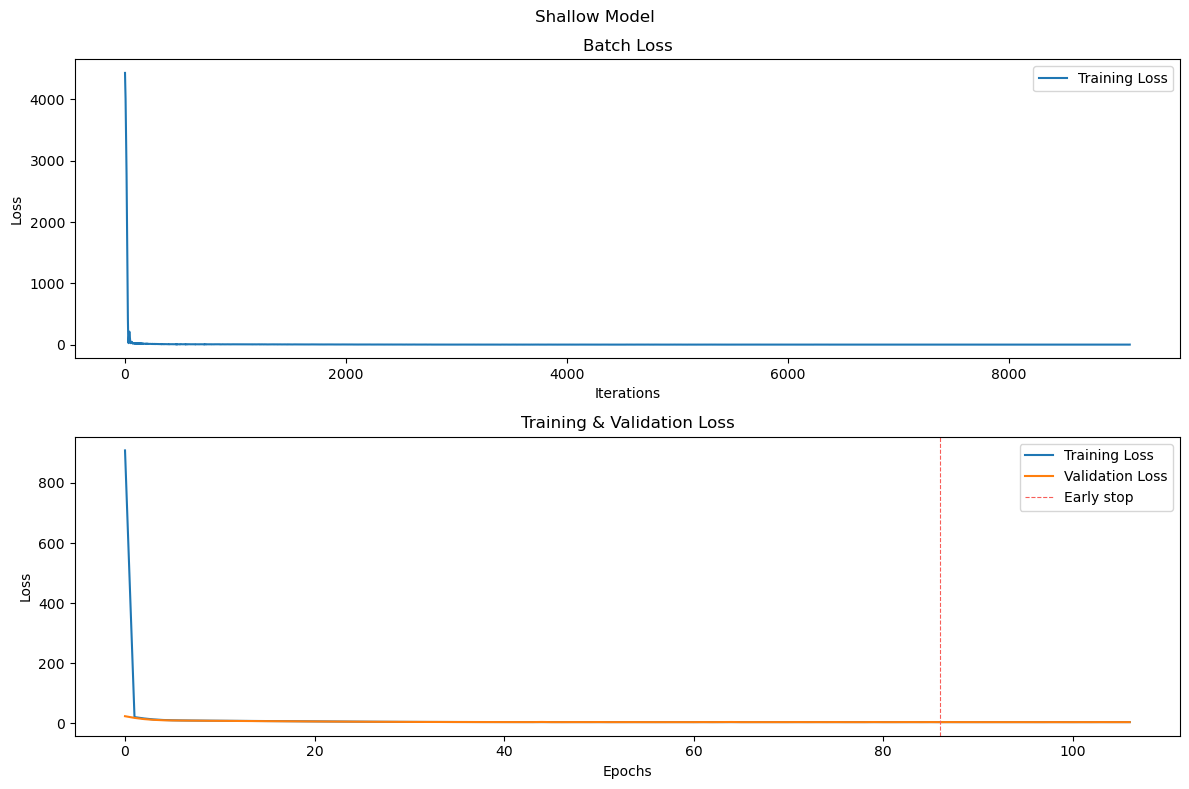

In [48]:
# Traning
# shallow model 
shallow = Model(inputDim=XTrain.shape[1], outputDim=1, hiddenLayers=[10])
shallow_trained = training(shallow, train, valid, maxEpoch=maxEpoch, batchSize = batchSize,
                           lr=lr, plot_error=True, title="Shallow Model")

In [49]:
pred_s = shallow_trained(XTest)

mse_s = nn.MSELoss()(pred_s, yTest)
print(f'The MSE for the best shallow nn model is {mse_s:.2f}.')

The MSE for the best shallow nn model is 3.38.


Epoch[ 1/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 71.94batch/s, valid_loss=9.26]


Validation loss decreased(      inf---> 9.256005)...saving model


Epoch[ 2/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 58.00batch/s, valid_loss=7.73]


Validation loss decreased( 9.256005---> 7.729109)...saving model


Epoch[ 3/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 70.02batch/s, valid_loss=4.91]


Validation loss decreased( 7.729109---> 4.913957)...saving model


Epoch[ 4/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 72.42batch/s, valid_loss=4.33]


Validation loss decreased( 4.913957---> 4.327094)...saving model


Epoch[ 5/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 59.27batch/s, valid_loss=2.47]


Validation loss decreased( 4.327094---> 2.471306)...saving model


Epoch[ 6/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 72.71batch/s, valid_loss=2.38]


Validation loss decreased( 2.471306---> 2.377807)...saving model


Epoch[10/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 69.90batch/s, valid_loss=2.1] 


Validation loss decreased( 2.377807---> 2.100731)...saving model


Epoch[12/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 68.31batch/s, valid_loss=1.99]


Validation loss decreased( 2.100731---> 1.986794)...saving model


Epoch[18/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 70.82batch/s, valid_loss=1.71]


Validation loss decreased( 1.986794---> 1.708303)...saving model


Epoch[23/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 69.78batch/s, valid_loss=1.6]  


Validation loss decreased( 1.708303---> 1.601780)...saving model


Epoch[24/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 70.69batch/s, valid_loss=1.39] 


Validation loss decreased( 1.601780---> 1.389952)...saving model


Epoch[34/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 58.68batch/s, valid_loss=1.25] 


Validation loss decreased( 1.389952---> 1.254248)...saving model


Epoch[36/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 69.14batch/s, valid_loss=1.09] 


Validation loss decreased( 1.254248---> 1.087635)...saving model


Epoch[47/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 59.03batch/s, valid_loss=0.904]


Validation loss decreased( 1.087635---> 0.904248)...saving model


Epoch[55/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 70.49batch/s, valid_loss=0.865]


Validation loss decreased( 0.904248---> 0.864684)...saving model


Epoch[65/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 68.43batch/s, valid_loss=0.821]


Validation loss decreased( 0.864684---> 0.821039)...saving model


Epoch[71/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 67.71batch/s, valid_loss=0.733]


Validation loss decreased( 0.821039---> 0.733318)...saving model


Epoch[72/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 68.94batch/s, valid_loss=0.706]


Validation loss decreased( 0.733318---> 0.705628)...saving model


Epoch[88/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 67.61batch/s, valid_loss=0.649]


Validation loss decreased( 0.705628---> 0.648660)...saving model


Epoch[92/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 66.04batch/s, valid_loss=0.628]


Validation loss decreased( 0.648660---> 0.628282)...saving model


Epoch[101/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 66.16batch/s, valid_loss=0.626]


Validation loss decreased( 0.628282---> 0.626131)...saving model


Epoch[107/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 67.98batch/s, valid_loss=0.605]


Validation loss decreased( 0.626131---> 0.605373)...saving model


Epoch[113/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 68.23batch/s, valid_loss=0.59] 


Validation loss decreased( 0.605373---> 0.589842)...saving model


Epoch[133/1000] valid: 100%|██████████| 22/22 [00:00<00:00, 64.73batch/s, valid_loss=0.719]



No improvment 20 consecutive epochs, early stopping.


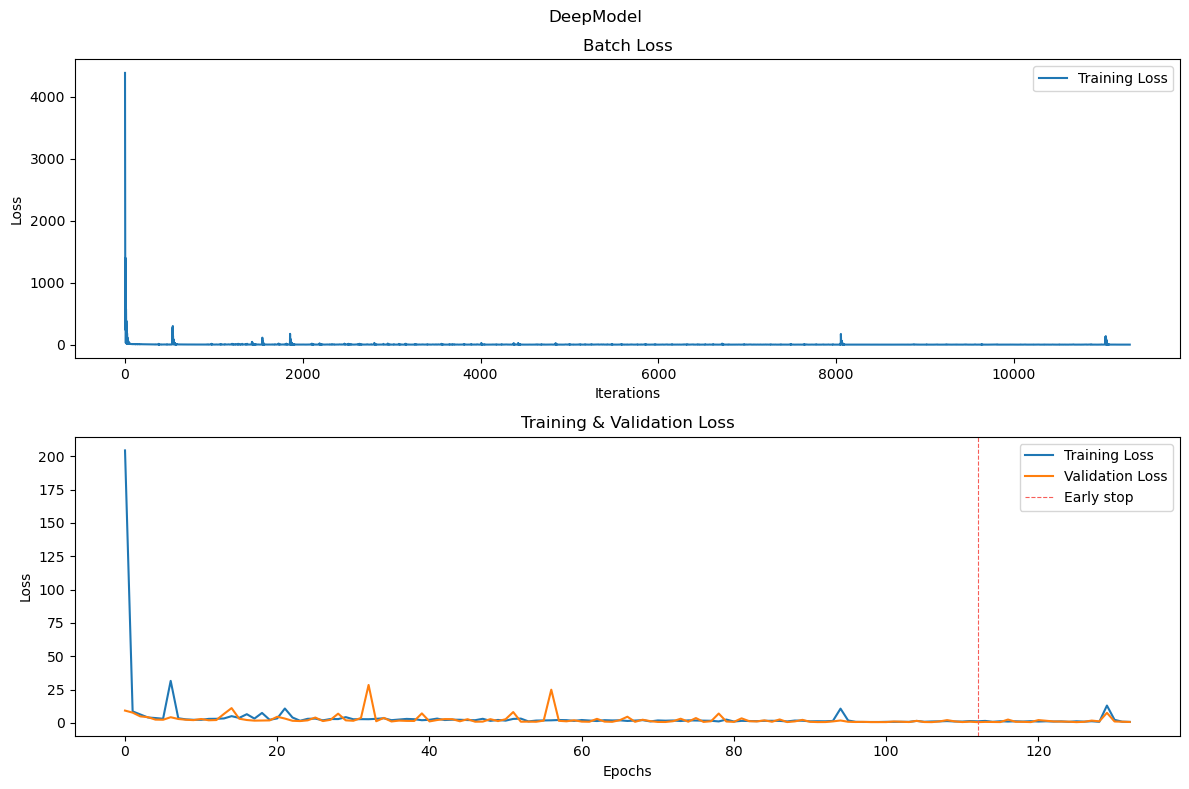

In [50]:
# Training for deep model 
# deep model 
deep = Model(inputDim=XTrain.shape[1], outputDim=1, hiddenLayers=[512, 256, 128, 64])
deep_trained = training(deep, train, valid, maxEpoch=1000, batchSize=batchSize, 
                           lr=lr, earlyStop=earlyStop, plot_error=True, title="DeepModel")

In [51]:
pred_d = deep_trained(XTest)

mse_d = nn.MSELoss()(pred_d, yTest)
print(f'The MSE for the best deep nn model is {mse_d:.2f}.')

The MSE for the best deep nn model is 0.73.


#### Comparison

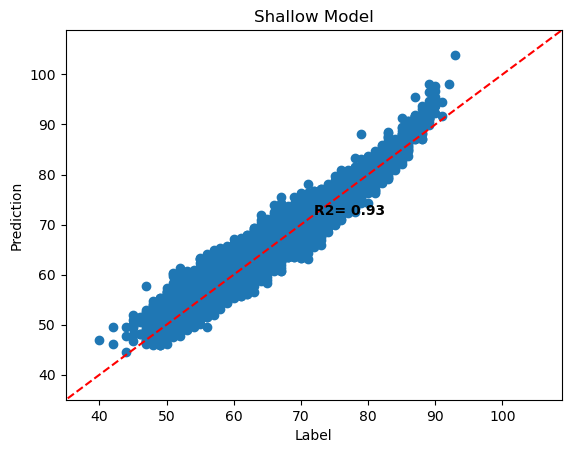

In [52]:
plot_r2(pred_s.detach().numpy(), yTest.detach().numpy(), title="Shallow Model")

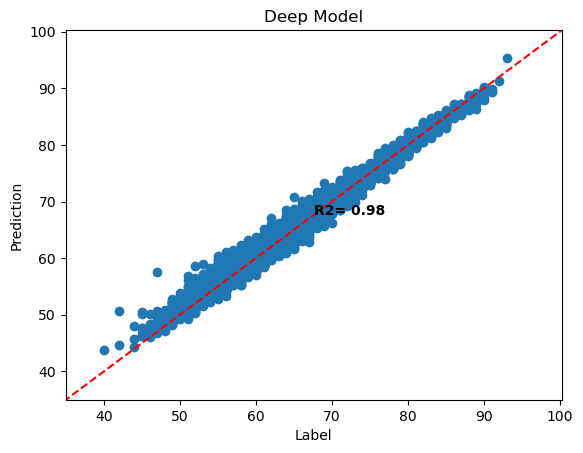

In [53]:
plot_r2(pred_d.detach().numpy(), yTest, title ="Deep Model")

In [54]:
print(f'''
The Mean Squared Error (MSE) of the best Decision Tree model on test data = {dtevaluator.evaluate(dt_cv_prediction_test):.4f}
The Mean Squared Error (MSE) of the best Linear Regression Model on test data = {lrevaluator.evaluate(lr_cv_prediction_test):.4f}
The Mean Squared Error (MSE) for the best shallow nn model is {mse_s:.4f}
The Mean Squared Error (MSE) for the best deep nn model is {mse_d:.4f}
''')

23/11/16 23:01:37 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB



The Mean Squared Error (MSE) of the best Decision Tree model on test data = 0.5631
The Mean Squared Error (MSE) of the best Linear Regression Model on test data = 3.2920
The Mean Squared Error (MSE) for the best shallow nn model is 3.3788
The Mean Squared Error (MSE) for the best deep nn model is 0.7263

